<a href="https://colab.research.google.com/github/pixelpercebe/Point-e-Google-Colab/blob/main/point_e_percebe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Cuaderno adaptado por Per_c_b*** 🤓
***Point-e*** generación de objetos 3D mediante *una nube de puntos*



---



## **1er paso** - *Preparar el entorno*

In [ ]:
#@title 🚨 **Ejecuta el siguiente chunk** o ten activada la Aceleración por hardware con GPU en `"Entorno de ejecución" > "Cambiar tipo de entorno de ejecución"` 
!nvidia-smi -L

In [ ]:
!pip install plotly -q

In [ ]:
!git clone https://github.com/openai/point-e

In [ ]:
%cd point-e

In [ ]:
! pip install -e .


---



## **2do paso** - *Codigo de la IA*

### **Importar**



In [ ]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

### **Modelos**

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

In [ ]:

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [ ]:
#@markdown ---
# Set a prompt to condition on.
# @markdown **Introduce lo que quieras generar:**
prompt = 'a green cactus' #@param {type:"string"}

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]

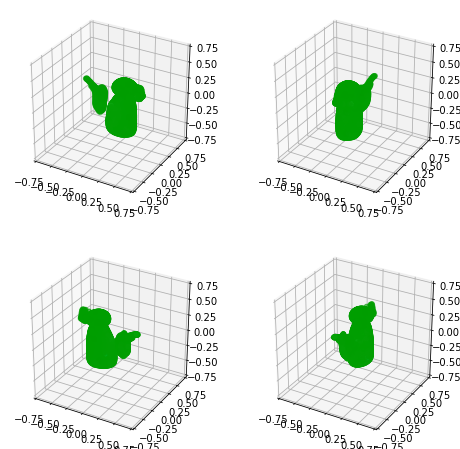

In [ ]:
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75,-0.75,-0.75),(0.75,0.75,0.75)))

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig_plotly = go.Figure(
    data=[
        go.Scatter3d(
            x=pc.coords[:,0],y=pc.coords[:,1],z=pc.coords[:,2],
            mode= 'markers',
            marker=dict(
                size=2,
                color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"],pc.channels["G"],pc.channels["B"])],
            )
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
        )
    ),
)

In [ ]:
fig_plotly.show(renderer="colab")